# Zigzag

## functions

In [4]:
import math
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

global ny, N, a1
ny = 10 # unit cell number in y direction
N = 2*ny
a1 = np.sqrt(3)/(2) # a = 1, a1 = a*sqrt(3)/2
    
def NB(T, E):
    # Bose distribution
    E = np.real(E)
    if abs(E/T) > 500:
        return 0
    else: return 1/(np.exp(E/T) - 1) 

def eigenv(H):
    '''  setup eigenvalues and eigenvectors
    parameters:
        H: np.ndarray
            Hamiltonian matrix
    returns:
        E: list
            eigenvalues
        U: np.ndarray
            eigenvectors
            U[i, m]: m: energy, i: sites
        U_dag: np.ndarray
            conjugate transpose of U
    '''
    
    E, U = np.linalg.eig(H)
    U_dag = np.conjugate(U).T
    
    return E, U, U_dag
    # return E

### 1 chain

In [ ]:
def hamiltonian_0_1c(j, J, d, h, k, obc=True):
    ''' H in A, B basis
    '''
    
    S = 0.5
    j, J, d = j*S, J*S, d*S
    
    ni = lambda i: i % N
    mat = np.zeros((N,N), dtype=np.complex128)
    
    A = []
    B = []
    for i in range(ny):
        A.append(i*2)
        B.append(i*2 + 1)
    
    phase = np.exp(-1j * k)
        
    ''' Periodic boundary condition '''

    for i in A:
        
        mat[i, i] += 3*j + 6*J + h
        
        # nearest neighbors
        mat[i, ni(i+1)] += -j*phase
        mat[i, ni(i+1)] += -j/phase
        mat[i, ni(i-1)] += -j
        
        # next nearest neighbors
        mat[i, ni(i)] += -(J-d*1j)*(phase**2)/2
        mat[i, ni(i)] += -(J+d*1j)/(phase**2)/2
        mat[i, ni(i+2)] += -(J+d*1j)*phase/2
        mat[i, ni(i-2)] += -(J-d*1j)/phase/2
        mat[i, ni(i-2)] += -(J+d*1j)*phase/2
        mat[i, ni(i+2)] += -(J-d*1j)/phase/2
        # h.c.
        mat[ni(i), i] += -(J+d*1j)/(phase**2)/2
        mat[ni(i), i] += -(J-d*1j)*(phase**2)/2
        mat[ni(i+2), i] += -(J-d*1j)/phase/2
        mat[ni(i-2), i] += -(J+d*1j)*phase/2
        mat[ni(i-2), i] += -(J-d*1j)/phase/2
        mat[ni(i+2), i] += -(J+d*1j)*phase/2
        
    for i in B:
        
        mat[i, i] = 3*j + 6*J + h
        
        # nearest neighbors
        mat[i, ni(i-1)] += -j/phase
        mat[i, ni(i-1)] += -j*phase
        mat[i, ni(i+1)] += -j
        
        # next nearest neighbors
        mat[i, ni(i+N)] += -(J+d*1j)*(phase**2)/2
        mat[i, ni(i-N)] += -(J-d*1j)/(phase**2)/2
        mat[i, ni(i+2)] += -(J-d*1j)*phase/2
        mat[i, ni(i-2)] += -(J+d*1j)/phase/2
        mat[i, ni(i-2+N)] += -(J-d*1j)*phase/2
        mat[i, ni(i+2-N)] += -(J+d*1j)/phase/2
        # h.c.
        mat[ni(i+N), i] += -(J-d*1j)/(phase**2)/2
        mat[ni(i-N), i] += -(J+d*1j)*(phase**2)/2
        mat[ni(i+2), i] += -(J+d*1j)/phase/2
        mat[ni(i-2), i] += -(J-d*1j)*phase/2
        mat[ni(i-2+N), i] += -(J+d*1j)/phase/2
        mat[ni(i+2-N), i] += -(J-d*1j)*phase/2

    ''' Open boundary condition (in y direction)'''
    if obc:
        for i in [0]: # first layer
            mat[i, ni(i-1)] = 0
            mat[i, ni(i-2)] = 0
            # mat[i, ni(i-2+N)] = 0
        
        for i in [1]: # second layer
            mat[i, ni(i-2)] = 0
            # mat[i, ni(i-2+N)] = 0
        
        for i in [N-1]: # last layer
            mat[i, ni(i+1)] = 0
            mat[i, ni(i+2)] = 0
            # mat[i, ni(i+2-N)] = 0
            
        for i in [N-2]: # second last layer
            mat[i, ni(i+2)] = 0
            # mat[i, ni(i+2-N)] = 0
    else: pass
    
    return mat

def hamiltonian_mft_1c(iteration, T, jn, J, d, h, kx, obc=True, txtout=None):
    ''' H in u, d basis
    '''
    
    H_0 = hamiltonian_0_1c(jn, J, d, h, kx, obc=obc)
    E, U, U_dag = eigenv(H_0) # 1st order eigenvalues and eigenvectors
    
    Ei = np.sort(E)
    if txtout is not None:
        with open(txtout, 'w') as f:
            for i in range(N):
                f.write(f'E{i},')
            f.write('\n')
            for i in range(N):
                f.write(f'{np.real(Ei[i])},')
            f.write('\n')
    
    H_1 = np.zeros((N, N), dtype=np.complex64)
    H_1 += U_dag @ H_0 @ U # 1st order H in u, d basis
    
    A = []
    B = []
    for i in range(ny):
        A.append(i*2)
        B.append(i*2 + 1)
        
    phase = np.exp(-1j * kx * a1)
        
    for iter in range(iteration):
        
        def V(m, n, i, j):
            if obc:
                if i < 0 or i >= N or j < 0 or j >= N:
                    return 0 # OBC
                else: return U_dag[m, i] * U[j, n]  
            else: 
                return U_dag[m, i % N] * U[j % N, n]
        
        N_b = 0
        for i in range(N):
            N_b += NB(T, E[i]) / N
        print(f'Number of bosons per site: {N_b}')
        
        for m in range(N):
            for n in range(N):
                
                for a in A:
                    # NN terms
                    H_1[m, n] += (jn*N_b) * (V(m,n,a,a-1) + V(m,n,a-1,a) - V(m,n,a-1,a-1))
                    H_1[m, n] += (jn*N_b) * ((V(m,n,a,a+1) + V(m,n,a+1,a)) * phase - V(m,n,a+1,a+1))
                    H_1[m, n] += (jn*N_b) * ((V(m,n,a,a+1) + V(m,n,a+1,a)) / phase - V(m,n,a+1,a+1))
                    H_1[m, n] -= (jn*N_b) * (3*V(m,n,a,a))
                    
                    # NNN terms
                    H_1[m, n] += (J*N_b/2) * ((V(m,n,a,a+2) + V(m,n,a+2,a)) * phase - V(m,n,a+2,a+2))
                    H_1[m, n] += (J*N_b/2) * ((V(m,n,a,a+2) + V(m,n,a+2,a)) / phase - V(m,n,a+2,a+2))
                    H_1[m, n] += (J*N_b/2) * ((V(m,n,a,a-2) + V(m,n,a-2,a)) * phase - V(m,n,a-2,a-2))
                    H_1[m, n] += (J*N_b/2) * ((V(m,n,a,a-2) + V(m,n,a-2,a)) / phase - V(m,n,a-2,a-2))
                    H_1[m, n] += (J*N_b/2) * ((V(m,n,a,a) + V(m,n,a,a)) * (phase**2) - V(m,n,a,a))
                    H_1[m, n] += (J*N_b/2) * ((V(m,n,a,a) + V(m,n,a,a)) / (phase**2) - V(m,n,a,a))
                    H_1[m, n] -= (J*N_b/2) * (6*V(m,n,a,a))
                    
                    # DMI terms
                    H_1[m, n] += (-1j*d*N_b/2) * (V(m,n,a+2,a) - V(m,n,a,a+2)) * phase
                    H_1[m, n] -= (-1j*d*N_b/2) * (V(m,n,a+2,a) - V(m,n,a,a+2)) / phase
                    H_1[m, n] += (-1j*d*N_b/2) * (V(m,n,a-2,a) - V(m,n,a,a-2)) * phase
                    H_1[m, n] -= (-1j*d*N_b/2) * (V(m,n,a-2,a) - V(m,n,a,a-2)) / phase
                    
                for b in B:
                    # NN terms
                    H_1[m, n] += (jn*N_b) * (V(m,n,b,b+1) + V(m,n,b+1,b) - V(m,n,b+1,b+1))
                    H_1[m, n] += (jn*N_b) * ((V(m,n,b,b-1) + V(m,n,b-1,b)) / phase - V(m,n,b-1,b-1))
                    H_1[m, n] += (jn*N_b) * ((V(m,n,b,b-1) + V(m,n,b-1,b)) * phase - V(m,n,b-1,b-1))
                    H_1[m, n] -= (jn*N_b) * (3*V(m,n,b,b))
                    
                    # NNN terms
                    H_1[m, n] += (J*N_b/2) * ((V(m,n,b,b+2) + V(m,n,b+2,b)) * phase - V(m,n,b+2,b+2))
                    H_1[m, n] += (J*N_b/2) * ((V(m,n,b,b+2) + V(m,n,b+2,b)) / phase - V(m,n,b+2,b+2))
                    H_1[m, n] += (J*N_b/2) * ((V(m,n,b,b-2) + V(m,n,b-2,b)) * phase - V(m,n,b-2,b-2))
                    H_1[m, n] += (J*N_b/2) * ((V(m,n,b,b-2) + V(m,n,b-2,b)) / phase - V(m,n,b-2,b-2))
                    H_1[m, n] += (J*N_b/2) * ((V(m,n,b,b) + V(m,n,b,b)) * (phase**2) - V(m,n,b,b))
                    H_1[m, n] += (J*N_b/2) * ((V(m,n,b,b) + V(m,n,b,b)) / (phase**2) - V(m,n,b,b))
                    H_1[m, n] -= (J*N_b/2) * (6*V(m,n,b,b))
                    
                    # DMI terms
                    H_1[m, n] += (1j*d*N_b/2) * (V(m,n,b+2,b) - V(m,n,b,b+2)) * phase
                    H_1[m, n] -= (1j*d*N_b/2) * (V(m,n,b+2,b) - V(m,n,b,b+2)) / phase
                    H_1[m, n] += (1j*d*N_b/2) * (V(m,n,b-2,b) - V(m,n,b,b-2)) * phase
                    H_1[m, n] -= (1j*d*N_b/2) * (V(m,n,b-2,b) - V(m,n,b,b-2)) / phase
        
        H_D = U @ H_1 @ U_dag # back to A, B basis
        E, U, U_dag = eigenv(H_D)
        H_1 = U_dag @ H_0 @ U # reset H_1 for next iteration
        print(f'det(UUdagger)={np.linalg.det(U@U_dag)}')
        
        Ei = np.sort(E)
        if txtout is not None:
            with open(txtout, 'a') as f:
                for i in range(N):
                    f.write(f'{np.real(Ei[i])},')
                f.write('\n')
    
        print(f'Iteration {iter} finished.')
        
        # with open(f'./H{T}{jn}{J}{d}.txt', 'a') as f:
        #     f.write(f'Iteration {iter} H matrix:\n')
        #     for i in range(N):
        #         for j in range(N):
        #             f.write('{0:.4f},'.format(np.real(H[i, j])))
        #         f.write('\n')
    
    return E

### 2 chain

### 3 chain

In [6]:
def hamiltonian_0_3c(j, J, d, h, k, boundary_site1='A', boundary_site2='B'):
    
    N3 = 3*N
    S = 0.5
    j, J, d = j*S, J*S, d*S
    
    ni = lambda i: i % N3
    mat = np.zeros((N3, N3), dtype=np.complex128)
    
    A = []
    B = []
    for i in range(ny*3):
        A.append(i*2)
        B.append(i*2 + 1)
    
    phase = np.exp(-1j * k * a1)
        
    ''' Periodic boundary condition '''

    for i in A:
        
        mat[i, i] += 3*j + 6*J + h
        
        # nearest neighbors
        mat[i, ni(i+1)] += -j*phase
        mat[i, ni(i+1-N)] += -j/phase
        mat[i, ni(i-1)] += -j
        
        # next nearest neighbors
        mat[i, ni(i+N)] += -(J-d*1j)*(phase**2)/2
        mat[i, ni(i-N)] += -(J+d*1j)/(phase**2)/2
        mat[i, ni(i+2)] += -(J+d*1j)*phase/2
        mat[i, ni(i-2)] += -(J-d*1j)/phase/2
        mat[i, ni(i-2+N)] += -(J+d*1j)*phase/2
        mat[i, ni(i+2-N)] += -(J-d*1j)/phase/2
        # h.c.
        mat[ni(i+N), i] += -(J+d*1j)/(phase**2)/2
        mat[ni(i-N), i] += -(J-d*1j)*(phase**2)/2
        mat[ni(i+2), i] += -(J-d*1j)/phase/2
        mat[ni(i-2), i] += -(J+d*1j)*phase/2
        mat[ni(i-2+N), i] += -(J-d*1j)/phase/2
        mat[ni(i+2-N), i] += -(J+d*1j)*phase/2
        # print([i, ni(i+N), ni(i-N), ni(i+2), ni(i-2), ni(i-2+N), ni(i+2-N)])
        
    for i in B:
        
        mat[i, i] = 3*j + 6*J + h
        
        # nearest neighbors
        mat[i, ni(i-1)] += -j/phase
        mat[i, ni(i-1+N)] += -j*phase
        mat[i, ni(i+1)] += -j
        
        # next nearest neighbors
        mat[i, ni(i+N)] += -(J+d*1j)*(phase**2)/2
        mat[i, ni(i-N)] += -(J-d*1j)/(phase**2)/2
        mat[i, ni(i+2)] += -(J-d*1j)*phase/2
        mat[i, ni(i-2)] += -(J+d*1j)/phase/2
        mat[i, ni(i-2+N)] += -(J-d*1j)*phase/2
        mat[i, ni(i+2-N)] += -(J+d*1j)/phase/2
        # h.c.
        mat[ni(i+N), i] += -(J-d*1j)/(phase**2)/2
        mat[ni(i-N), i] += -(J+d*1j)*(phase**2)/2
        mat[ni(i+2), i] += -(J+d*1j)/phase/2
        mat[ni(i-2), i] += -(J-d*1j)*phase/2
        mat[ni(i-2+N), i] += -(J+d*1j)/phase/2
        mat[ni(i+2-N), i] += -(J-d*1j)*phase/2

    ''' Open boundary condition (in y direction)'''
    
    for i in [0, N, 2*N]: # first layer
        mat[i, ni(i-1)] = 0
        mat[i, ni(i-2)] = 0
        mat[ni(i-1), i] = 0
        mat[ni(i-2), i] = 0
        mat[i, ni(i-2+N)] = 0
        mat[ni(i-2+N), i] = 0
    
    for i in [1, N+1, 2*N+1]: # second layer
        mat[i, ni(i-2)] = 0
        mat[i, ni(i-2+N)] = 0
        mat[ni(i-2), i] = 0
        mat[ni(i-2+N), i] = 0
    
    for i in [N-1, 2*N-1, 3*N-1]: # last layer
        mat[i, ni(i+1)] = 0
        mat[i, ni(i+2)] = 0
        mat[ni(i+1), i] = 0
        mat[ni(i+2), i] = 0
        mat[i, ni(i+2-N)] = 0
        mat[ni(i+2-N), i] = 0
        
    for i in [N-2, 2*N-2, 3*N-2]: # second last layer
        mat[i, ni(i+2)] = 0
        mat[i, ni(i+2-N)] = 0
        mat[ni(i+2), i] = 0
        mat[ni(i+2-N), i] = 0
        
    # ''' Different boundary sites '''
    # sites_tobe_removed = [0, N]
            
    # if boundary_site1 == 'A':
    #     pass 
    # elif boundary_site1 == 'B':
    #     sites_tobe_removed[0] = n
    #     for i in B[:n]:
    #         row, rowp, rowm, x, y = labels(i)
    #         mat[ni(i), ni(i-1)] = 0
    #         mat[ni(i), ni((i+1)%n2+row)] = 0
            
    #         mat[ni(i), ni((i+2)%n2+row)] = 0
    #         mat[ni(i), ni((i-2)%n2+row)] = 0
            
    #     for i in A[n:2*n]:
    #         row, rowp, rowm, x, y = labels(i)
            
    #         mat[ni(i), ni(y)] = 0
    #         mat[ni(i), ni((y+2)%n2+rowm)] = 0
    # else:
    #     print('Error: boundary_site1 should be A or B')
    #     return
    
    # if boundary_site2 == 'B':
    #     pass
    # elif boundary_site2 == 'A':
    #     sites_tobe_removed[1] = N-n
    #     for i in A[-n:]:
    #         row, rowp, rowm, x, y = labels(i)
    #         mat[ni(i), ni(i+1)] = 0
    #         mat[ni(i), ni((i-1)%n2+row)] = 0
            
    #         mat[ni(i), ni((i+2)%n2+row)] = 0
    #         mat[ni(i), ni((i-2)%n2+row)] = 0
            
    #     for i in B[-2*n:-n]:
    #         row, rowp, rowm, x, y = labels(i)
    #         mat[ni(i), ni(x)] = 0
    #         mat[ni(i), ni((x-2)%n2+rowp)] = 0
    # else:
    #     print('Error: boundary_site2 should be A or B')
    #     return
        
    # return mat[sites_tobe_removed[0]: sites_tobe_removed[1], sites_tobe_removed[0]: sites_tobe_removed[1]]
    # print(sites_tobe_removed)
    return mat


## 1st order

In [25]:
j = 1
J = 0.1
D = 0.1
h = 0.1
T = 0.1

K = np.pi/a1
spec = np.linspace(0, K, 201)
Erp_1c = []
Erp_3c = []
# bc = ['A', 'B'] # boundary condition
for k in spec:
    E_1c = 0
    H_1c = hamiltonian_0_1c(j, J, D, h, k)
    E_1c, _, _ = eigenv(H_1c)
    Erp_1c.append(np.real(E_1c))
    E_3c = 0
    H_3c = hamiltonian_0_3c(j, J, D, h, k)
    E_3c, _, _ = eigenv(H_3c)
    Erp_3c.append(np.real(E_3c))
Er_1c = np.array(Erp_1c)
Er_3c = np.array(Erp_3c)
bands_1c = np.array([spec] * len(E_1c))/K
bands_3c = np.array([spec] * len(E_3c))/K

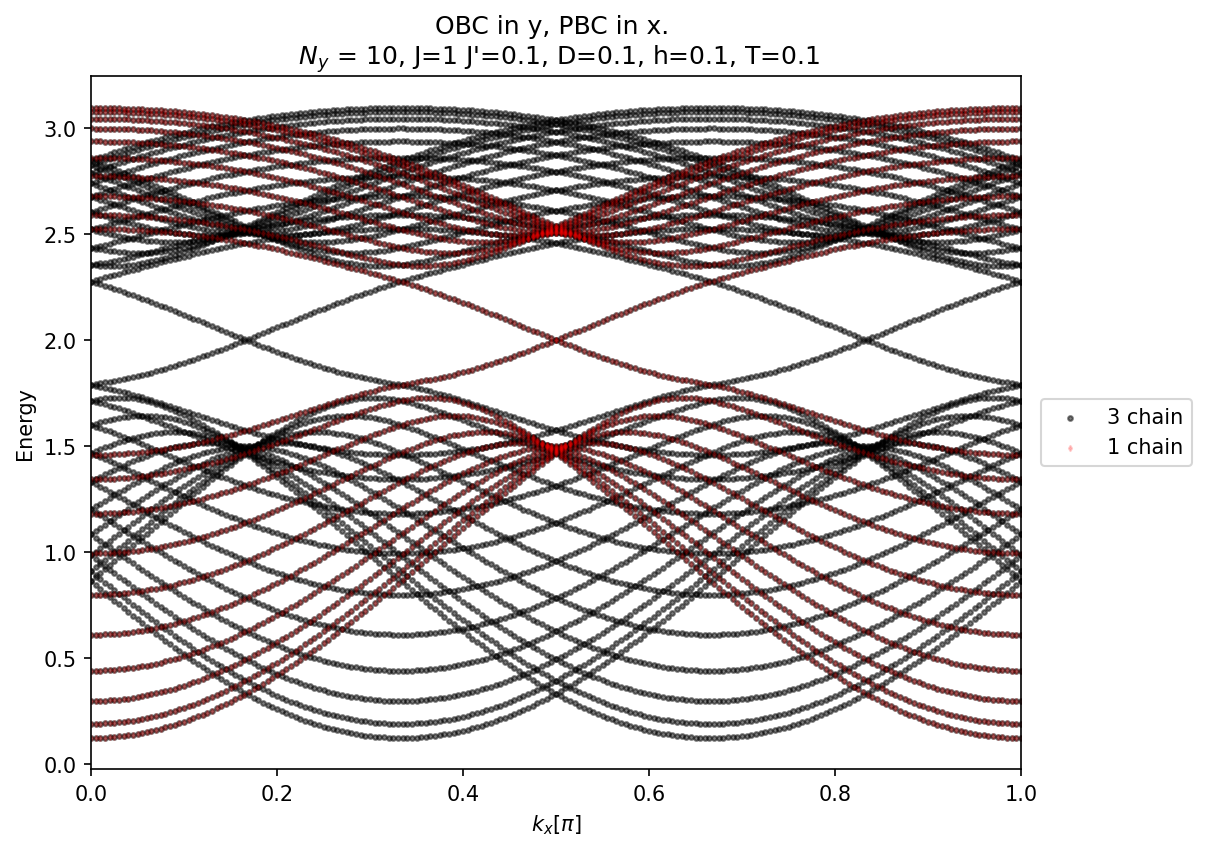

In [26]:
fig, ax = plt.subplots(figsize=(8,6), dpi=150)

for i in range(len(E_3c)-1):
    ax.scatter(bands_3c[i, :], Er_3c[:,i], 
        color='k', s=5, alpha=0.5, marker='o')
ax.scatter(bands_3c[len(E_3c)-1, :], Er_3c[:,len(E_3c)-1], 
    color='k', s=5, alpha=0.5, marker='o', label='3 chain')
    
for i in range(len(E_1c)-1):
    ax.scatter(bands_1c[i, :], Er_1c[:,i], 
        color='r', s=3, alpha=0.2, marker='d')
ax.scatter(bands_1c[len(E_1c)-1, :], Er_1c[:,len(E_1c)-1], 
    color='r', s=3, alpha=0.2, marker='d', label='1 chain')

ax.legend(bbox_to_anchor=(1.01, 0.55))
ax.set_xlabel('$k_x [\\pi]$')
ax.set_ylabel('Energy')
ax.set_xlim(0, 1)
# ax.set_xlim(0.5, 1.5)
# ax.set_ylim(0, 4)
title = f"OBC in y, PBC in x. \n $N_y$ = {ny}, J={j} J'={J}, D={D}, h={h}, T={T}"
ax.set_title(title)

# plt.savefig(f'./louvre/cylinder_m{m}_J{j}_Jp{J}_D{D}_h{h}_T{T}_{bc[0]}{bc[1]}.png', dpi=100)

plt.show()

## 2nd order

### spectrum

In [115]:
j = 1
J = 0.1
D = 0.
h = 0.1
T = 0.1
OBC = False

iter = 20

K = np.pi/a1
spec = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.45, 0.5, 0.55, 0.6, 0.7, 0.8, 0.9, 1.0])*K
# spec = np.linspace(0, K, 11)
# spec = np.linspace(0.4*K, 0.6*K, 11)
E_1 = []
E_2 = []
# bc = ['A', 'B'] # boundary condition
for k in spec:
    Ea = 0
    Eb = 0
    Ea, _, _ = eigenv(hamiltonian_0_1c(j, J, D, h, k, obc=OBC))
    E_1.append(np.real(Ea))
    Eb = hamiltonian_mft_1c(iter, T, j, J, D, h, k, obc=OBC)
    E_2.append(np.real(Eb))
    
E1 = np.array(E_1)
E2 = np.array(E_2)
bands = np.array([spec] * len(Ea))/K

Number of bosons per site: 0.044938325250308976
det(UUdagger)=(1.0000000000000004+0j)
Iteration 0 finished.
Number of bosons per site: 0.10992453798241983
det(UUdagger)=(0.20128904852662055+0j)
Iteration 1 finished.
Number of bosons per site: 0.055927330582131396
det(UUdagger)=(0.9961089494163536+0j)
Iteration 2 finished.
Number of bosons per site: 0.17567874817184445
det(UUdagger)=(0.6092960469742867+0j)
Iteration 3 finished.
Number of bosons per site: 0.0695588949591443
det(UUdagger)=(1+0j)
Iteration 4 finished.
Number of bosons per site: 0.08006812199599182
det(UUdagger)=(0.9782940175657656+0j)
Iteration 5 finished.
Number of bosons per site: 0.05204987643760939
det(UUdagger)=(1.0000000000000002+0j)
Iteration 6 finished.
Number of bosons per site: 0.04922433965356975
det(UUdagger)=(0.7869463926987216+0j)
Iteration 7 finished.
Number of bosons per site: 0.04886156768141867
det(UUdagger)=(1.0000000000000002+0j)
Iteration 8 finished.
Number of bosons per site: 0.048968105209624725
det(

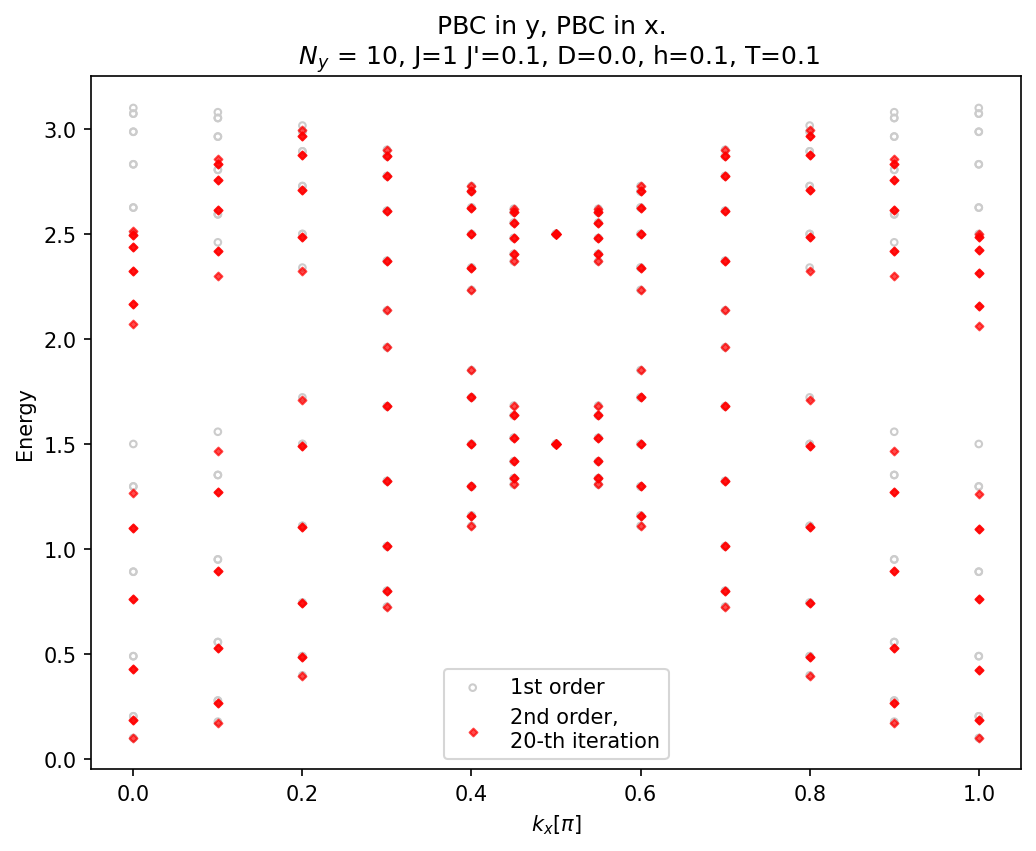

In [ ]:
fig, ax = plt.subplots(figsize=(8,6), dpi=150)

for i in range(len(Ea)-1):
    ax.scatter(bands[i, :], E1[:,i], 
        color='#CCCCCC', s=10, facecolors='none', marker='o')
    ax.scatter(bands[i, :], E2[:,i], 
        edgecolors='r', facecolors='r', s=7, alpha=0.7, marker='D', zorder=10)

ax.scatter(bands[N-1, :], E1[:,N-1], 
    color='#CCCCCC', s=10, facecolors='none', marker='o', label='1st order', zorder=1)
ax.scatter(bands[N-1, :], E2[:,N-1], 
    edgecolors='r', facecolors='r', s=7, alpha=0.7, marker='D', label=f'2nd order, \n{iter}-th iteration', zorder=10)
    
ax.set_xlabel('$k_x [\\pi]$')
ax.set_ylabel('Energy')
# ax.set_xlim(0, 1)
# ax.set_xlim(0.5, 1.5)
# ax.set_ylim(0, 5)
ax.legend()
title = f"PBC in y, PBC in x. \n $N_y$ = {ny}, J={j} J'={J}, D={D}, h={h}, T={T}"
ax.set_title(title)

# plt.savefig(f'./louvre/MagnonMFT_{ny}_J{j}_Jp{J}_D{D}_h{h}_T{T}_itr{iter}.png', dpi=100)

plt.show()

### convergence

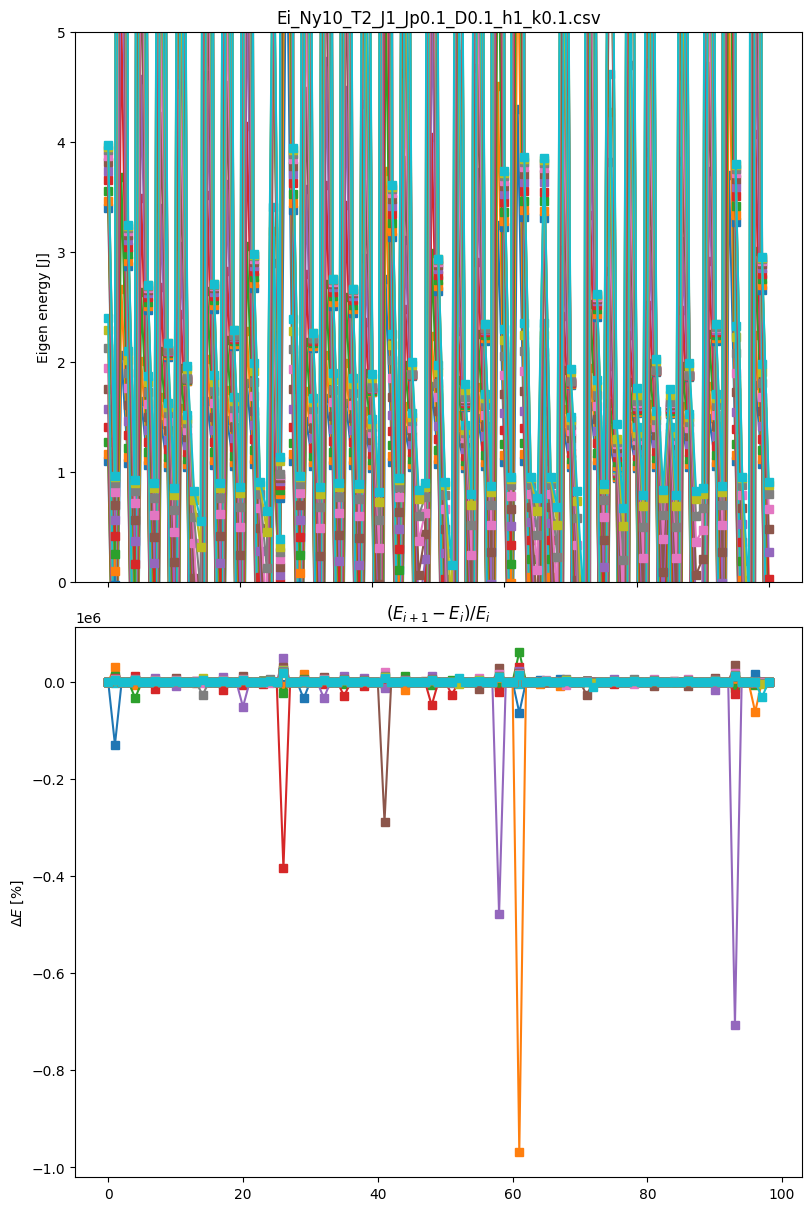

In [114]:
file = f'Ei_Ny{10}_T{2}_J{1}_Jp{0.1}_D{0.1}_h{1}_k{0.1}.csv'
iterations = 100

fig, axs = plt.subplots(2, 1, figsize=(8, 12), layout='constrained')

data = pd.read_csv('./data/' + file)

ax = axs[0]
for i in range(len(data.columns)):
    ax.plot(data.iloc[:, i], label=f'E{i}', marker='s')
    
ax.set_ylim(0, 5)
ax.set_ylabel('Eigen energy [J]')
ax.label_outer()
ax.set_title(file)

ax = axs[1]
for i in range(len(data.columns)):
    delta = []
    for j in range(iterations-1):
        delta.append(100*(data.iloc[j+1, i]-data.iloc[j, i])/data.iloc[j, i])
    ax.plot(delta, label=f'E{i}', marker='s')

# ax.set_ylim(-200, 200)
ax.set_ylabel('$\Delta E$ [%]')
ax.set_title('$(E_{i+1} - E_i)/E_i$')

plt.savefig(f'./louvre/{file[:-4]}.png', dpi=100)
plt.show()

In [113]:
j = 1
J = 0.1
D = 0.1
h = 1
T = 2

iter = 100

k = 0.1
K = k*np.pi/a1

file = f'./data/Ei_Ny{ny}_T{T}_J{j}_Jp{J}_D{D}_h{h}_k{k}.csv'

hamiltonian_mft_1c(iter, T, j, J, D, h, K, obc=True, txtout=file)
# hamiltonian_mft(3, T, j, J, D, h, K)

Number of bosons per site: 0.507806179385915
det(UUdagger)=(0.9999999998893386-2.7903146556452793e-24j)
Iteration 0 finished.
Number of bosons per site: -3.0908383059401534
det(UUdagger)=(1.0000000000000009+4.151139804024486e-24j)
Iteration 1 finished.
Number of bosons per site: 0.06183395413952481
det(UUdagger)=(1.0000000000000002+7.783785622810442e-32j)
Iteration 2 finished.
Number of bosons per site: 0.5926554197844581
det(UUdagger)=(0.9999999999999991+1.505242719376157e-31j)
Iteration 3 finished.
Number of bosons per site: -1.7410435453397544
det(UUdagger)=(1+6.686114921348348e-31j)
Iteration 4 finished.
Number of bosons per site: 0.10832336596008899
det(UUdagger)=(1.0000000000000009+4.715805431059169e-31j)
Iteration 5 finished.
Number of bosons per site: 0.6801066111996639
det(UUdagger)=(1.0000000000000009-3.5486551437479995e-31j)
Iteration 6 finished.
Number of bosons per site: -1.0631478633574036
det(UUdagger)=(1.0000000000000002-4.742045087885444e-31j)
Iteration 7 finished.
Num

array([ 0.91154825+4.12918136e-17j,  0.87834835+4.19313334e-17j,
        0.79593813+2.07358414e-17j,  0.66351211+2.64281511e-17j,
        0.48630541+1.63584818e-17j,  0.2722523 +2.67920117e-17j,
        0.03209727-4.64919044e-18j, -0.21922845+2.36902725e-17j,
       -0.4586981 +1.11577190e-17j, -0.64659408+1.94320576e-17j,
       -3.54462127+4.75522465e-18j, -3.47641127-2.51976865e-18j,
       -3.36503043-1.81910439e-17j, -3.21406948-1.43469326e-17j,
       -3.02893071-1.83999886e-17j, -2.12607792-3.15033445e-17j,
       -2.19838939-1.53165290e-17j, -2.37298329-2.08140850e-17j,
       -2.59202375-3.79584292e-18j, -2.81753258-3.71633460e-17j])